<a href="https://colab.research.google.com/github/Weichunchou/Hands-on-AI/blob/main/LightGBM_JournalClub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial for LightGBM

In [ ]:
## Connect the google colab with google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Install python packages to run this notebook
!pip install -q lightgbm # install the lightgbm package
!pip install -q scikit-optimize # install the package used for Bayesian optimization

     |████████████████████████████████| 100 kB 5.5 MB/s 


In [ ]:
#Install basic python pcakges
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from time import time


Set your working directory to a speicifc folder in your Google Drive

In [ ]:
# Set your working directory to a speicifc folder in your Google Drive
# The base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/Test Folder/" # Name your project here. Please instead the "my project folder" to your prefer name

# Make sure that floder exists. If not, automatically create a new folder
if (not os.path.isdir(root_dir + project_folder)):
  os.mkdir(root_dir + project_folder)
  print(root_dir + project_folder + 'did not exist but was created.')

# Change the OS to use your project folder as the working directory
os.chdir(root_dir + project_folder)

If you have your own data, you can use the following code:

In [ ]:
# importer Data
Data = pd.read_csv(os.path.join(root_dir + project_folder + "data.csv"))

In [ ]:
## Qickly check the description of data
Data.info()

In [ ]:
# Check the data strcuture
Data.describe()

,AMID_N,ATSC6se,IC1,AATS1Z,EState_VSA5,MATS2d,AETA_dBeta,GATS2v,ATSC7i,SMR_VSA3,BCUTp-1h,SMR_VSA5,AATS2m,fr_C_O_noCOO,ka,V1,"CLh,int"
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.00000,246.000000
mean,0.147122,-0.212010,2.987837,28.745528,8.699959,-0.088836,-0.067620,0.964167,-5.379474,4.871667,2.199065,25.845203,104.122764,0.695122,5.477195,0.60547,20.068565
std,0.159211,1.105102,0.643261,11.398129,10.950565,0.154233,0.259019,0.173599,21.014294,6.598248,0.465215,31.186039,90.441095,0.990020,11.312643,0.46932,70.256843
min,0.000000,-3.090000,0.918000,15.000000,0.000000,-0.600000,-0.667000,0.324000,-119.000000,0.000000,1.230000,0.000000,23.200000,0.000000,0.176000,0.01120,0.009350
25%,0.000000,-0.703000,2.700000,21.925000,0.000000,-0.188250,-0.229250,0.873000,-9.565000,0.000000,1.980000,6.420000,64.275000,0.000000,1.480000,0.26925,0.433000
50%,0.119500,-0.042750,3.125000,25.750000,5.560000,-0.084600,-0.050750,0.958500,0.000000,0.000000,2.000000,18.900000,82.300000,0.000000,2.665000,0.49900,1.815000
75%,0.234750,0.142250,3.437500,30.175000,12.100000,0.023675,0.125000,1.067500,3.862500,9.780000,2.210000,37.475000,105.750000,1.000000,6.157500,0.81950,7.610000
max,0.768000,4.350000,4.600000,88.800000,45.100000,0.356000,0.563000,1.500000,51.700000,30.400000,5.360000,197.000000,913.000000,5.000000,158.000000,2.81000,527.000000


# Data Cleaning  
Most Machine leanring algorithms canot work with missing features. So, we need to use some functions to take care of them as following code:

In [ ]:
#from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(strategy="median")

# Since the median can only be computed on numerical attributes
Data_num = Data.drop(["Compound","ka","V1","CLh,int"], axis=1)
Data_label_ka = Data[['ka']]
Data_label_V1 = Data[['V1']]
Data_label_CL = Data[['CLh,int']].rename(columns={'CLh,int':'CL'})


# Feature Scaling

## Transformation Pipelines

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer


num_pipeline = Pipeline([
  #('imputer', SimpleImputer(strategy="median")), 
  (('STD_scaler', StandardScaler())) # StandardScaler used for feature scaling
])
Data_num_tr = pd.DataFrame(num_pipeline.fit_transform(Data_num))
Data_num_tr.columns = list(Data_num.columns)
Data_num_tr

,AMID_N,ATSC6se,IC1,AATS1Z,EState_VSA5,MATS2d,AETA_dBeta,GATS2v,ATSC7i,SMR_VSA3,BCUTp-1h,SMR_VSA5,AATS2m,fr_C_O_noCOO
0,0.200634,-0.136002,0.455116,-0.373235,0.951663,-0.657255,0.965675,0.495442,0.249790,-0.739833,-0.471850,-0.608086,-0.265051,0.308579
1,1.679674,0.192237,-1.336295,-0.593017,-0.239741,-3.320990,2.439607,1.130376,0.256513,-0.739833,-0.601086,-0.830432,-0.580816,-0.703561
2,0.389447,0.545866,0.782243,-0.408400,-0.347718,1.285322,0.068163,-0.110633,-0.001932,0.068086,-0.428772,0.644381,-0.304937,2.332859
3,1.484567,-0.045328,0.408383,0.013580,-0.796096,1.165129,0.876698,-0.878327,0.002359,1.507760,0.023553,-0.396664,-0.023519,-0.703561
4,-0.069999,0.155061,-1.476492,-0.496313,-0.287324,-0.030303,1.824502,0.437720,0.456308,-0.739833,-0.428772,-0.830432,-0.333744,-0.703561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,-0.925955,-0.850512,0.050101,-0.408400,-0.796096,-0.631268,1.035310,-0.202987,0.461553,-0.739833,-0.450311,-0.608086,-0.270591,-0.703561
242,-0.925955,-0.277453,-1.383027,1.103696,-0.796096,-0.501329,-2.225910,0.957212,0.226043,-0.739833,-0.665704,0.907855,1.051189,-0.703561
243,-0.925955,0.192237,-1.538802,3.802611,-0.796096,-1.456375,1.549832,-1.738375,0.256513,-0.739833,1.854391,-0.830432,2.967936,-0.703561
244,-0.925955,-0.850512,-1.445337,-0.962249,-0.796096,0.032717,-1.092413,1.996197,0.366186,-0.739833,-0.687243,0.438742,-0.678315,-0.703561


In [ ]:
X = Data_num_tr
y = Data_label_CL

In [ ]:
y.describe()

,CL
count,246.000000
mean,20.068565
std,70.256843
min,0.009350
25%,0.433000
50%,1.815000
75%,7.610000
max,527.000000


#Select and Train a Model

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2, random_state = 42)

In [ ]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 10000
}

In [ ]:
gbm = lgb.LGBMRegressor(**hyper_params, random_state = 42)

In [ ]:
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric= 'l1',
        early_stopping_rounds=1000)


In [ ]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

In [ ]:
# Basic RMSE
from sklearn.metrics import mean_absolute_error

print('The rmse of prediction is:', round(mean_absolute_error(y_pred, y_test)**0.5, 5))

The rmse of prediction is: 5.72337


In [ ]:
from sklearn.metrics import r2_score


test_preds = gbm.predict(X_test)
train_preds = gbm.predict(X_train)

print("\nTest R2 Score : %.2f"%r2_score(y_test, test_preds))
print("Train R2 Score : %.2f"%r2_score(y_train, train_preds))


Test R2 Score : 0.17
Train R2 Score : 0.35


# Better Evaluation Using Cross-Validation

In [ ]:
#Cross Validation

from sklearn.model_selection import cross_val_score

scores = cross_val_score(gbm, X_train, y_train,cv=5, verbose=1)

gbm_rmse_scores = np.sqrt(-scores)

In [ ]:
## Define a fuction to report the values
def display_scores (scores):

  print("Scores:", scores)
  print("Mean", scores.mean())
  print("Standard dviation:", scores.std())

display_scores (gbm_rmse_scores)

In [ ]:
pd.Series(np.sqrt(-scores)).describe()

# Fine-Tune Your Model  


## Grid Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## DEFINE A FUNCTION TO RUN BOTH GRIDSEARCH AND RANDOMSEARCH WITH CROSS-VALIDATION
def algorithm_pipeline(X_train, X_test, y_train, y_test, 
            model, param_grid, cv=10, scoring_fit= 'neg_mean_squared_error', 
            search_mode = 'GridSearchCV', n_iterations = 0):
  '''
  A function to return corss-validated LightGBM model and evalauted metrics

  Inputs:
    scoring_fit: The parameters that control what metric to evaluate the model

  '''
  fitted_model = None
  
  if(search_mode == 'GridSearchCV'):
    gs = GridSearchCV(
        estimator = model,
        param_grid = param_grid, 
        cv = cv, 
        n_jobs = -1, 
        scoring = scoring_fit
    )
    fitted_model = gs.fit(X_train, y_train)
  
  elif (search_mode == 'RandomizedSearchCV'):
    rs = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid, 
        cv=cv,
        n_iter=n_iterations,
        n_jobs=-1,
        scoring = scoring_fit,
        random_state = 42
    )
    
    fitted_model = rs.fit(X_train, y_train)
  
  elif (search_mode == 'BayesSearchCV'):
    bs = BayesSearchCV(
        estimator=model,
        search_spaces = param_grid,
        cv = cv,
        n_iter=n_iterations,
        n_jobs = -1,
        scoring=scoring_fit,
        random_state = 42
    )

    fitted_model = bs.fit(X_train, y_train)
        
  if (search_mode == 'BayesSearchCV'):
    pred = None
  else:  
    pred = fitted_model.predict(X_test)
    
  return fitted_model, pred

In [ ]:
# Grid search  hyperparameter tuning
param_grid = {
    'learning_rate': [0.005, 0.05, 0.5],
    'metric': ['l1','l2'],
    'max_depth': [3, 7, 10, None],
    'n_estimators': [100,200,300],
    'min_samples_split':[2,3,5,7,10],
    'num_iterations': [10,100,300]
}

In [ ]:
import time
start = time.time()

model = lgb.LGBMRegressor()

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                 param_grid, cv=5)

print(model.best_score_)
print(model.best_params_)

end = time.time()

0.2814978818359576
{'learning_rate': 0.05, 'max_depth': 3, 'metric': 'l1', 'min_samples_split': 2, 'n_estimators': 100, 'num_iterations': 300}


In [ ]:
from sklearn.metrics import mean_squared_error

print('best params')
print(model.best_params_)
preds_lgb_model = model.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, preds_lgb_model))
print(" RMSE: %f" % (rmse_lgb ))

best params
{'learning_rate': 0.05, 'max_depth': 3, 'metric': 'l1', 'min_samples_split': 2, 'n_estimators': 100, 'num_iterations': 300}
 RMSE: 77.699111


In [ ]:
from sklearn.metrics import r2_score


test_preds = model.predict(X_test)
train_preds = model.predict(X_train)

print("\nTest R2 Score : %.2f"%r2_score(y_test, test_preds))
print("Train R2 Score : %.2f"%r2_score(y_train, train_preds))


Test R2 Score : 0.21
Train R2 Score : 0.84


## Random Search

In [ ]:
# Random search hyperparameter tuning
param_grid = {
    'n_estimators': [10, 100, 100, 1000, 5000],
    'num_leaves' : [20, 40, 60, 80, 100],
    'min_child_samples': [10, 20, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [-1,5,10,100, 500],
    'min_split_gain': [0, 10, 50, 100],
    'reg_alpha':[0, 0.001, 0.01, 0.1],
    'reg_lambda':[0, 0.001, 0.01, 0.1]
}

In [ ]:
import time
start = time.time()

model = lgb.LGBMRegressor()

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                 param_grid, search_mode = 'RandomizedSearchCV',
                 scoring_fit='r2',
                 cv = 5, n_iterations = 100)

print(model.best_score_)
print(model.best_params_)

end = time.time()

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import mean_squared_error

print('best params')
print(model.best_params_)
y_hat = model.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, preds_lgb_model))
print(" RMSE: %f" % (rmse_lgb ))

best params
{'reg_lambda': 0.001, 'reg_alpha': 0.01, 'num_leaves': 40, 'n_estimators': 100, 'min_split_gain': 10, 'min_child_samples': 20, 'max_depth': 100, 'learning_rate': 0.1}
 RMSE: 78.921898


In [ ]:
from sklearn.metrics import r2_score


test_preds = model.predict(X_test)
train_preds = model.predict(X_train)

print("\nTest R2 Score : %.2f"%r2_score(y_test, test_preds))
print("Train R2 Score : %.2f"%r2_score(y_train, train_preds))


Test R2 Score : 0.19
Train R2 Score : 0.80


## Bayesian optimization

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RepeatedStratifiedKFold
from skopt import gp_minimize

In [ ]:
search_spaces = {
    'learning_rate': Real(0.0001, 1, 'log-uniform'),
    'n_estimators': Integer(10, 100),
    'subsample': Real(0.01, 1.0, 'uniform'),  
    'num_leaves': Integer(2, 256),
    'max_depth': Integer(-1, 512),
    'subsample_freq': Integer(0, 1000),
    'reg_alpha': Real(0.0, 1, 'uniform'),
    'reg_lambda': Real(0.0, 1, 'uniform')
    }  

In [ ]:
import time
start = time.time()

model = lgb.LGBMRegressor(random_state = 42)
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                 param_grid = search_spaces, 
                 search_mode = 'BayesSearchCV', 
                 cv = 5, n_iterations = 100)

print(model.best_score_)
print(model.best_params_)

end = time.time()


-2040.1270283381077
OrderedDict([('learning_rate', 0.26262369731330965), ('max_depth', -1), ('n_estimators', 77), ('num_leaves', 256), ('reg_alpha', 0.0), ('reg_lambda', 1.0), ('subsample', 0.9066201985111967), ('subsample_freq', 1000)])


In [ ]:
from sklearn.metrics import mean_squared_error

print('best params:')
print(model.best_params_)
preds_lgb_model = model.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, preds_lgb_model))
print(" RMSE: %f" % (rmse_lgb ))

best params:
OrderedDict([('learning_rate', 0.26262369731330965), ('max_depth', -1), ('n_estimators', 77), ('num_leaves', 256), ('reg_alpha', 0.0), ('reg_lambda', 1.0), ('subsample', 0.9066201985111967), ('subsample_freq', 1000)])
 RMSE: 76.065987


In [ ]:
from sklearn.metrics import r2_score

test_preds = model.predict(X_test)
train_preds = model.predict(X_train)

print("\nTest R2 Score : %.2f"%r2_score(y_test, test_preds))
print("Train R2 Score : %.2f"%r2_score(y_train, train_preds))


Test R2 Score : 0.25
Train R2 Score : 0.84


# Nested cross validation with BayesSearchCV

In [ ]:
# Loading required packages
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score

# Define the model
model = lgb.LGBMRegressor(random_state = 42)

# define search space
search_spaces = {
    'learning_rate': Real(0.001, 1, 'log-uniform'),
    'n_estimators': Integer(10, 1000),
    'subsample': Real(0.01, 1.0, 'uniform'),  
    'num_leaves': Integer(2, 256),
    'max_depth': Integer(-1, 512),
    'subsample_freq': Integer(0, 1000),
    'reg_alpha': Real(0.0, 1, 'uniform'),
    'reg_lambda': Real(0.0, 1, 'uniform')
    }  

# configure the cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state = 1)

# enumerate splits
outer_results = list()
best_params = list()

# Loop for each round
for train_ix, test_ix in cv_outer.split(X):
  
  # Split data
  X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
  y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

  # Define both cross-validation objects (inner & outer)
  cv_inner = KFold(n_splits=5, shuffle=True, random_state = 1)

  # Define the model
  model = lgb.LGBMRegressor(random_state = 42)

  # define search
  bs = BayesSearchCV(
        estimator = model,
        search_spaces = search_spaces,
        cv = cv_inner,
        n_iter = 50,
        n_jobs = -1,
        refit  =True,
        scoring = "neg_mean_squared_error",
        random_state = 42
    )
  # execute search
  result = bs.fit(X_train, y_train)

  # get the best parameters on the whole training set
  best_model = result.best_estimator_

  # evaluate model on the hold out dataset
  y_pre = best_model.predict(X_train)
  y_hat = best_model.predict(X_test)

  # evalaute the model
  r_square_pre = r2_score(y_train, y_pre)
  r_square_hat = r2_score(y_test, y_hat)

  # store the result
  #outer_results.append(r_square_pre)
  outer_results.append(r_square_hat)
  best_params.append(result.best_params_)
  # report progress
  print('>r2=%.3f, est=%.3f, cfg=%s' % (r_square_hat, r_square_pre, result.best_params_))

 ## loop end here-----------------------------------------------------------


>r2=-0.221, est=0.732, cfg=OrderedDict([('learning_rate', 0.013062771342669609), ('max_depth', 284), ('n_estimators', 525), ('num_leaves', 169), ('reg_alpha', 0.5179183866936355), ('reg_lambda', 1.0), ('subsample', 0.2740959189197519), ('subsample_freq', 0)])
>r2=-5.849, est=0.786, cfg=OrderedDict([('learning_rate', 0.03640323638356523), ('max_depth', 336), ('n_estimators', 300), ('num_leaves', 59), ('reg_alpha', 0.9623244236004678), ('reg_lambda', 0.5891255697155572), ('subsample', 0.8392875064598487), ('subsample_freq', 9)])
>r2=0.542, est=0.587, cfg=OrderedDict([('learning_rate', 0.006259728927131546), ('max_depth', 510), ('n_estimators', 798), ('num_leaves', 6), ('reg_alpha', 1.0), ('reg_lambda', 0.0), ('subsample', 1.0), ('subsample_freq', 0)])
>r2=-0.047, est=0.035, cfg=OrderedDict([('learning_rate', 0.0022807839811021884), ('max_depth', 374), ('n_estimators', 978), ('num_leaves', 256), ('reg_alpha', 0.0), ('reg_lambda', 0.0), ('subsample', 0.2910924054565741), ('subsample_freq',

In [ ]:
# summarize the estimated performance of the model
print('r2: %.3f (%3f)' % (mean(outer_results), std(outer_results)))


r2: -1.091 (2.392560)


In [ ]:
hyper_params = {
    'learning_rate': 0.006259728927131546,
    'n_estimators': 798,
    'subsample': 1,
    "subsample_freq":0,
    "max_depth": 510,
    "num_leaves": 6,  
    "reg_lambda": 0.0,
    "reg_alpha": 1.0,
    "random_state": 42
} 

In [ ]:
model = lgb.LGBMRegressor(**best_params[2])
model.fit(X_train, y_train)
y_hat=model.predict(X)
r_square_hat = r2_score(y, y_hat)
r_square_hat

0.6056612597923832

# Nested cross validation with Baysian Optimization

In [ ]:
# manually tune svm model hyperparameters using skopt on the ionosphere dataset
from numpy import mean
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize


# Define the search space of hyperparameters
search_space = list()
search_space.append(Real(1e-4, 1, 'log-uniform', name = 'learning_rate'))
search_space.append(Real(1e-2, 1, 'uniform', name = 'subsample'))
search_space.append(Real(0, 1, 'uniform', name = 'reg_alpha'))
search_space.append(Real(0, 1, 'uniform', name = 'reg_lambda'))
search_space.append(Integer(-1, 512, name = 'max_depth'))
search_space.append(Integer(2, 256, name = 'num_leaves'))
search_space.append(Integer(1e1, 1e3, name = 'n_estimators'))
search_space.append(Integer(0, 1e3, name = 'subsample_freq'))

# Define the function used to evalaute a given configuration
@use_named_args(search_space)
def evaluate_model (**params):
  # configure the model with specific hyperparameters
  model = lgb.LGBMRegressor()
  model.set_params(**params)
  
  # define test harness
  cv_inner = KFold(n_splits=5, shuffle=True, random_state = 1)
 
  # execute the nested cross-validation
  results = cross_val_score(model, X, y,
                scoring = 'neg_mean_absolute_error', 
                cv=cv_inner, n_jobs=-1)
  # calculate the mean of the scores
  scores = -np.mean(results)
  
  return np.sqrt(scores)

# perform optimzation
result = gp_minimize(evaluate_model, search_space)

# summarizing finding:
print('Best Accuracy: %.3f' % (result.fun))
print('Best Parameters: %s' % (result.x))


Best Accuracy: 4.940
Best Parameters: [0.0036518362610079803, 0.8701090015474595, 0.6731934729828777, 0.6869998383300765, 482, 229, 723, 467]


# Scatter plot

In [ ]:
# prediction
y_hat = model.predict(X)
r_square_pre = r2_score(y, y_hat)
print(np.sqrt(r_square_pre))

0.7782424171120353


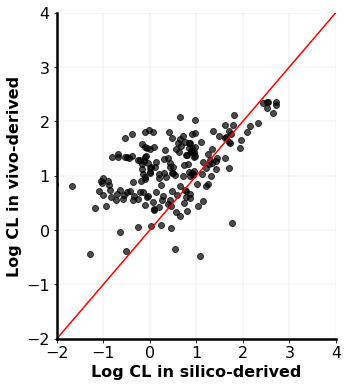

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms


def scatterplot(x, y):
  fig, ax = plt.subplots(figsize = (5,6))
  
  # define a scatter plot
  ax.scatter(x, y, alpha=0.7, c='black')

  line = mlines.Line2D([0, 1], [0, 1], color='red')
  transform = ax.transAxes
  line.set_transform(transform)
  ax.add_line(line)

  # add title and aces labels
  ax.set_title ('')
  ax.set_xlabel ('Log CL in silico-derived', fontsize=16, fontweight='bold')
  ax.set_ylabel ('Log CL in vivo-derived', fontsize=16, fontweight='bold')
  ax.set_xlim(-2, 4)
  ax.set_ylim(-2, 4)

  # remove the top and right borders
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_linewidth(2.5)
  ax.spines['bottom'].set_linewidth(2.5)
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)

  # adds major gridlines
  ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha = 0.5)
  plt.show()

scatterplot(np.log10(y), np.log10(y_hat))